
### Price Trajectories
Modeled by [Wiener Process](https://en.wikipedia.org/wiki/Wiener_process)

### Data:
#### The Graph (Compound-v2)
Used for current total borrowed

#### Coingecko (Historical Prices)
Use file: `data/coingeckoe_prices.csv`

Created by download script `download_historical_prices.py`. The script has a runtime of ~1h, because it sends about 600 requests to coingecko. The free API allows 10-50 requests / minute, so I use a sleep of 6 seconds to never send more than 10 requests / minute. 

Time window: `2022-11-21` to `2022-11-20`

Should be updated if gets too old compared to the timestamp of data from The Graph. 


## Assumptions

- total supply = total borrows + free
- when asset is twice in graph list (wbtc, dai) only take the one with bigger borrows, drop the other
- exchange rate and collateral factor don't change

## documentation
- If an asset has a 0% collateral factor, it can’t be used as collateral (or seized in liquidation), though it can still be borrowed.

In [1]:
import pandas as pd
from pathlib import Path
import json

from src.coingecko import CoingeckoAPI
from src.the_graph import TheGraphAPI

PRICES_FILE = Path.cwd().joinpath("data", "coingecko_prices.csv")
PARAMS_FILE = Path.cwd().joinpath("configs", "parameters.json")


In [2]:
# get current Compound Borrows from The Graph

tg_api = TheGraphAPI()
borrows = tg_api.get_compound_borrows()

col_dtypes = {
    "underlyingSymbol":str,
    "underlyingName":str, 
    "borrowRate":float,	
    "totalBorrows":float,	
    "collateralFactor":float,	
    "underlyingPriceUSD":float,	
    "blockTimestamp":int,	
    "accrualBlockNumber":int
    }
borrows_df = pd.DataFrame(borrows)
borrows_df = borrows_df.apply(lambda c: c.astype(col_dtypes[c.name]))
borrows_df

,underlyingSymbol,underlyingName,borrowRate,totalBorrows,collateralFactor,underlyingPriceUSD,blockTimestamp,accrualBlockNumber
0,USDP,Pax Dollar,0.033163,1.973460e+04,0.000,1.000000,1669065083,16020988
1,TUSD,TrueUSD,0.034016,5.487027e+06,0.000,1.000000,1669086671,16022778
2,REP,Reputation,0.030407,5.590882e+01,0.000,6.961100,1667094731,15857708
3,UNI,Uniswap,0.041803,4.302477e+05,0.750,5.137000,1669098011,16023719
4,USDC,USD//C,0.018775,2.543348e+08,0.855,1.000000,1669098443,16023755
5,SUSHI,SushiToken,0.071891,6.625372e+05,0.700,1.127000,1669098299,16023743
6,ETH,Ether,0.023007,1.377674e+04,0.825,1097.350000,1669098407,16023751
7,DAI,Dai Stablecoin,0.022915,1.816424e+08,0.835,1.000110,1669099235,16023821
8,BAT,Basic Attention Token,0.020875,4.445730e+05,0.650,0.218834,1669057811,16020387
9,COMP,Compound,0.025794,1.034877e+04,0.650,37.230000,1669097891,16023709


Have two entries for `DAI` and `wBTC` each... only keep the bigger one for now
```
{
  "underlyingSymbol": "DAI",
  "underlyingName": "Dai Stablecoin",
  "borrowRate": "0.0233026004452608",
  "totalBorrows": "211524161.923877439677332104",
  "collateralFactor": "0.835",
  "underlyingPriceUSD": "1.000773",
  "blockTimestamp": 1669045535,
  "accrualBlockNumber": 16019369
},
{
  "underlyingSymbol": "DAI",
  "underlyingName": "Dai Stablecoin v1.0 (DAI)",
  "borrowRate": "0.0501467542606656",
  "totalBorrows": "240.64852988575940222",
  "collateralFactor": "0",
  "underlyingPriceUSD": "6.210826",
  "blockTimestamp": 1668979619,
  "accrualBlockNumber": 16013904
},
....
{
  "underlyingSymbol": "WBTC",
  "underlyingName": "Wrapped BTC",
  "borrowRate": "0.0206864728473312",
  "totalBorrows": "0.39387562",
  "collateralFactor": "0.7",
  "underlyingPriceUSD": "15929.996902",
  "blockTimestamp": 1669001867,
  "accrualBlockNumber": 16015751
},
{
  "underlyingSymbol": "WBTC",
  "underlyingName": "Wrapped BTC",
  "borrowRate": "0.0221761103560704",
  "totalBorrows": "152.21575285",
  "collateralFactor": "0.7",
  "underlyingPriceUSD": "16182.771321",
  "blockTimestamp": 1669043411,
  "accrualBlockNumber": 16019192
},
```

In [3]:
borrows_df = borrows_df.sort_values(by=["underlyingSymbol", "totalBorrows"], ascending=False).reset_index(drop=True)
borrows_df = borrows_df.drop_duplicates(subset=["underlyingSymbol"])
borrows_df

,underlyingSymbol,underlyingName,borrowRate,totalBorrows,collateralFactor,underlyingPriceUSD,blockTimestamp,accrualBlockNumber
0,ZRX,0x Protocol Token,0.032438,4.962302e+05,0.650,0.180324,1669096991,16023635
1,YFI,yearn.finance,0.020050,3.181422e-02,0.750,6194.460000,1668777299,15997132
2,WBTC,Wrapped BTC,0.022178,1.520192e+02,0.700,15786.567555,1669098431,16023754
4,USDT,Tether USD,0.037028,1.638698e+08,0.000,1.000000,1669097819,16023704
5,USDP,Pax Dollar,0.033163,1.973460e+04,0.000,1.000000,1669065083,16020988
6,USDC,USD//C,0.018775,2.543348e+08,0.855,1.000000,1669098443,16023755
7,UNI,Uniswap,0.041803,4.302477e+05,0.750,5.137000,1669098011,16023719
8,TUSD,TrueUSD,0.034016,5.487027e+06,0.000,1.000000,1669086671,16022778
9,SUSHI,SushiToken,0.071891,6.625372e+05,0.700,1.127000,1669098299,16023743
10,REP,Reputation,0.030407,5.590882e+01,0.000,6.961100,1667094731,15857708


### Monte Carlo Simulation
- Calculate Volatilties
- Simulate Price Paths

In [4]:
from src.measures import calc_volatility, monte_carlo_simulation

with open(PARAMS_FILE) as f:
    params = json.load(f)
    
# load historical prices from coingecko (used scrip `download_historica_prices.ipynb` to prepare data)
prices = pd.read_csv(PRICES_FILE)

# calculate volatilities
vols = {}
for symbol in prices["symbol"].unique():
    p = prices[prices["symbol"] == symbol]["price"].values
    vols[symbol] = calc_volatility(p)

print(vols)

{'usdp': 0.0043466418878502005, 'tusd': 0.00282056858179138, 'rep': 0.07171938656321616, 'uni': 0.0697395479254225, 'usdc': 0.0021574718617547875, 'sushi': 0.09514300836715131, 'eth': 0.06422278659986509, 'dai': 0.002007655992637203, 'bat': 0.06004059637910412, 'comp': 0.06638834095565146, 'fei': 0.02851061647386272, 'yfi': 0.06864343781384731, 'zrx': 0.0728031524419769, 'wbtc': 0.04429704461003883, 'aave': 0.07464626572283103, 'usdt': 0.0019460020558690057, 'link': 0.07018952104224735}


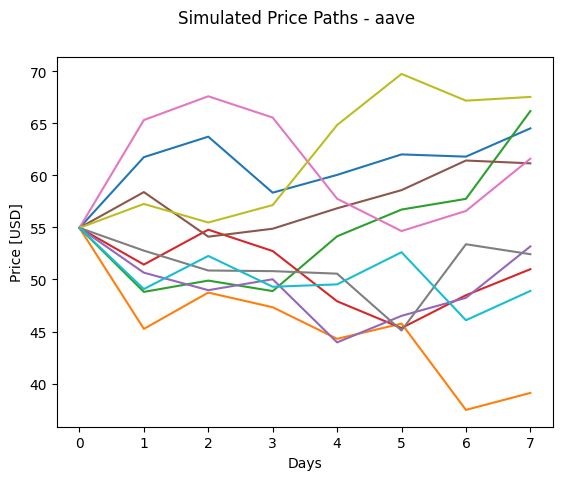

In [5]:
# plot example of Monte Carlo Paths (aave)
from src.plots import plot_mc_paths
from matplotlib import pyplot as plt

symbol = "aave"
price = borrows_df[borrows_df["underlyingSymbol"] == symbol.upper()]["underlyingPriceUSD"].iloc[0]
paths = monte_carlo_simulation(price, vols[symbol], params["mc_horizon"], params["mc_paths"])

fig = plot_mc_paths(symbol, paths)
plt.show()

In [9]:
# Simulate Monte Carlo Paths for all Symbols
mc_paths = {}
for symbol in prices["symbol"].unique():
    price = borrows_df[borrows_df["underlyingSymbol"] == symbol.upper()]["underlyingPriceUSD"].iloc[0]
    mc_paths[symbol] = monte_carlo_simulation(price, vols[symbol], params["mc_horizon"], params["mc_paths"])
